   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   i

/tmp/ipykernel_13/4263188699.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key="Date", freq="M"))[sales_col].sum().reset_index()


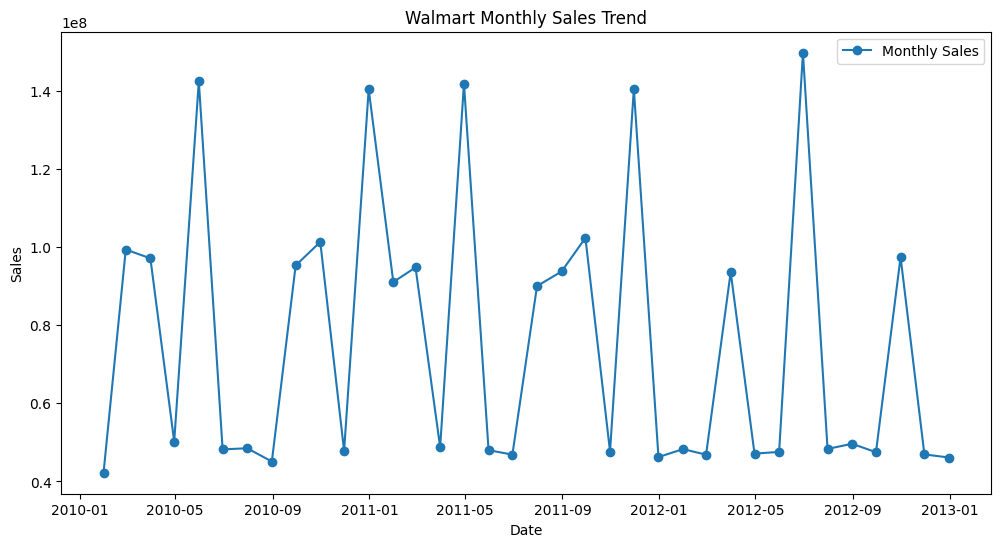

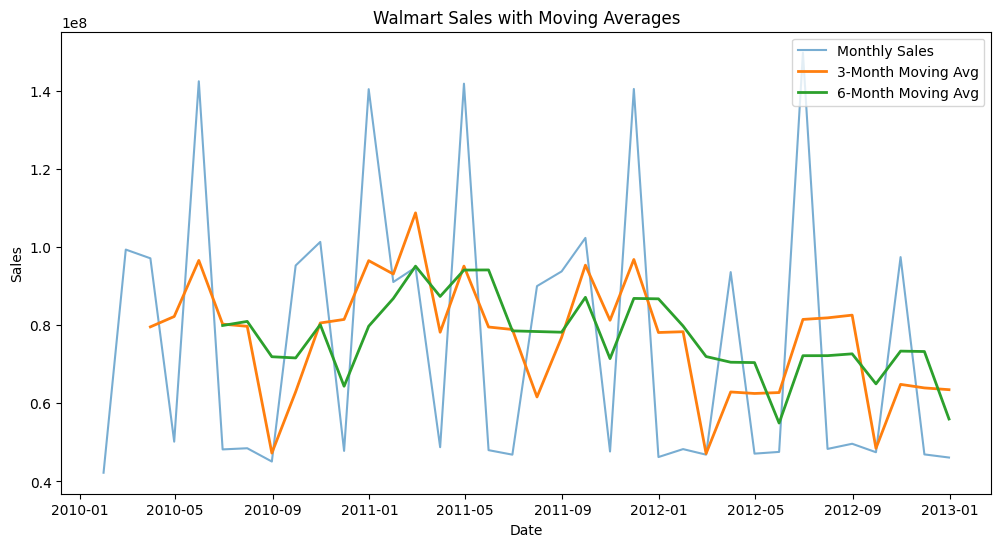

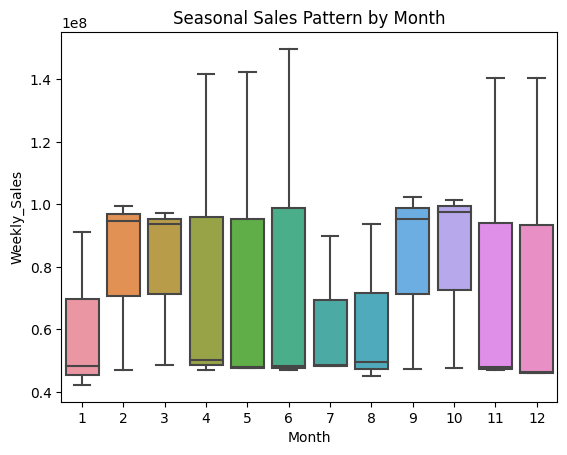

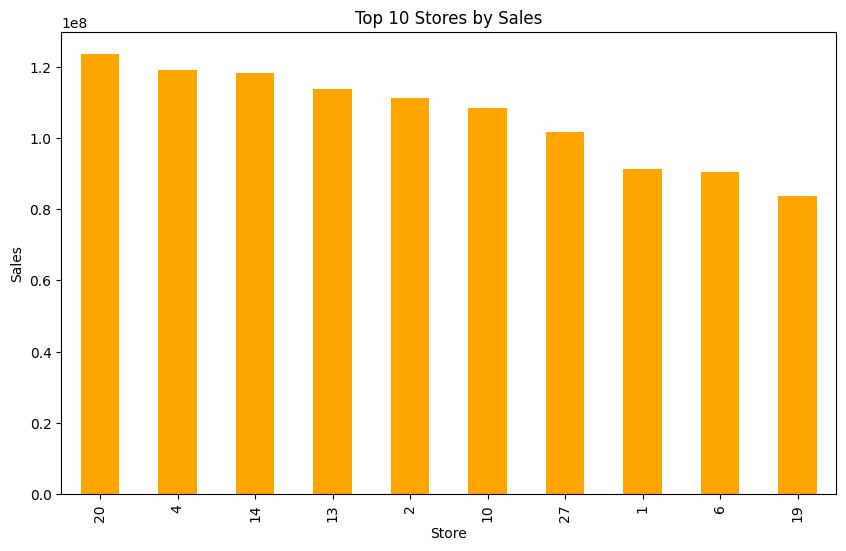

/tmp/ipykernel_13/4263188699.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=monthly_sales["Date"].iloc[-1] + pd.offsets.MonthBegin(),


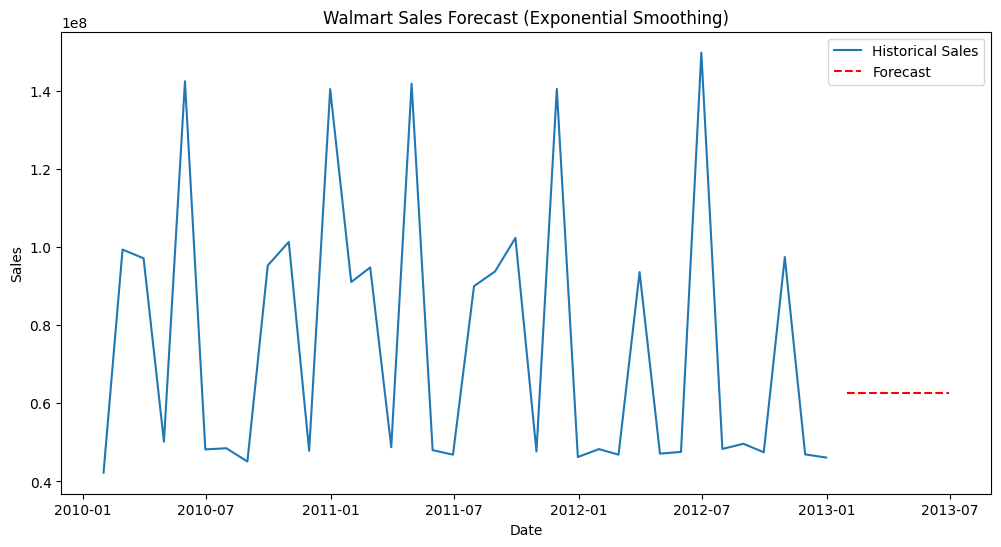

In [1]:
# --- Walmart Sales Forecasting (Time Series Analysis) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load dataset ---
file_path = "/kaggle/input/walmart-forecasting/Walmart.csv"
df = pd.read_csv(file_path)

# --- Inspect data ---
print(df.head())
print(df.info())

# --- Convert date column safely ---
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])
    df = df.sort_values("Date")
else:
    raise KeyError("Dataset must contain a 'Date' column.")

# --- Identify sales column ---
if "Weekly_Sales" in df.columns:
    sales_col = "Weekly_Sales"
elif "Sales" in df.columns:
    sales_col = "Sales"
elif "Revenue" in df.columns:
    sales_col = "Revenue"
else:
    raise KeyError("No sales column found. Expected Weekly_Sales, Sales, or Revenue.")

# --- Aggregate monthly sales ---
monthly_sales = df.groupby(pd.Grouper(key="Date", freq="M"))[sales_col].sum().reset_index()

# --- Plot sales trend ---
plt.figure(figsize=(12,6))
plt.plot(monthly_sales["Date"], monthly_sales[sales_col], marker="o", label="Monthly Sales")
plt.title("Walmart Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# --- Moving averages (3 & 6 months) ---
monthly_sales["MA_3"] = monthly_sales[sales_col].rolling(3).mean()
monthly_sales["MA_6"] = monthly_sales[sales_col].rolling(6).mean()

plt.figure(figsize=(12,6))
plt.plot(monthly_sales["Date"], monthly_sales[sales_col], label="Monthly Sales", alpha=0.6)
plt.plot(monthly_sales["Date"], monthly_sales["MA_3"], label="3-Month Moving Avg", linewidth=2)
plt.plot(monthly_sales["Date"], monthly_sales["MA_6"], label="6-Month Moving Avg", linewidth=2)
plt.title("Walmart Sales with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# --- Seasonal patterns (month wise) ---
monthly_sales["Month"] = monthly_sales["Date"].dt.month
sns.boxplot(x="Month", y=sales_col, data=monthly_sales)
plt.title("Seasonal Sales Pattern by Month")
plt.show()

# --- Revenue breakdown by product & region ---
if "Dept" in df.columns:
    dept_sales = df.groupby("Dept")[sales_col].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,6))
    dept_sales.plot(kind="bar")
    plt.title("Top 10 Product Departments by Sales")
    plt.ylabel("Sales")
    plt.show()

if "Store" in df.columns:
    store_sales = df.groupby("Store")[sales_col].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,6))
    store_sales.plot(kind="bar", color="orange")
    plt.title("Top 10 Stores by Sales")
    plt.ylabel("Sales")
    plt.show()

# --- Simple Forecasting (Exponential Smoothing) ---
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(monthly_sales[sales_col]).fit(smoothing_level=0.2, optimized=False)

# Forecast next 6 months
forecast = model.forecast(6)

# Generate forecast dates starting after the last date
forecast_dates = pd.date_range(start=monthly_sales["Date"].iloc[-1] + pd.offsets.MonthBegin(),
                               periods=6, freq="M")

plt.figure(figsize=(12,6))
plt.plot(monthly_sales["Date"], monthly_sales[sales_col], label="Historical Sales")
plt.plot(forecast_dates, forecast, label="Forecast", linestyle="--", color="red")
plt.title("Walmart Sales Forecast (Exponential Smoothing)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()
